# Imports and Utility Functions

In [ ]:
!sudo apt update
!sudo apt install xvfb
!pip install gym
!pip install ma-gym
!pip3 install box2d-py
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://devel

In [ ]:
import os
from pyvirtualdisplay import Display
import gym
import ma_gym
from gym import spaces
from gym import logger as gymlogger
from ma_gym.wrappers import Monitor
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from tqdm import tqdm
import time 
from google.colab import widgets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos  = 0
    
    def push(self, state, action, reward, next_state, done):

        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        batch = np.asarray(list(zip(*samples)))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]
        
        return states, actions, rewards, next_states, dones, indices

    def __len__(self):
        return len(self.buffer)

In [ ]:
def get_target(model, next_state, reward, gamma, done):
  model.eval()
  with torch.no_grad():
      next_q_values = model(next_state)      # next_q_values has dimensions batch, num_actions
      next_q_value = next_q_values.max(1)[0]

  expected_q_value = reward+gamma*next_q_value*(1-done)  # If terminal state (1-done) will be 0.
  
  return expected_q_value

In [ ]:
def loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer):
    state, action, reward, next_state, done, indices = replay_buffer.sample(batch_size) 

    state = torch.tensor(state.astype('float') ).float().to(device) 
    next_state = torch.tensor(next_state.astype('float') ).float().to(device)
    action = torch.tensor(action.astype('float') ).long().to(device)
    reward = torch.tensor(reward.astype('float') ).float().to(device)
    done = torch.tensor(done.astype('float') ).float().to(device)
    
    dqn_model.train()

    q_values = dqn_model(state) #feedforward

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1) # Q values for actions sampled from the replay buffer

    expected_q_value = get_target(target_model, next_state, reward, gamma, done)

    loss = F.mse_loss(q_value,expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, device):
        super().__init__()

        # sequential model
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 64),  # INPUT LAYER
            nn.ReLU(),
            nn.Linear(64, 128),  # HIDDEN LAYER 1
            nn.ReLU(),
            nn.Linear(128, 256),  # HIDDEN LAYER 2
            nn.ReLU(),
            nn.Linear(256, num_actions),  # OUTPUT LAYER
        )

        self.num_actions = num_actions
        self.device = device

    def forward(self, x):
        op = self.layers(x)
        return op

    def act(self, state, epsilon, env, i):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0].item()
        else:
            action = np.random.choice(env.action_space[i].n)

        return action

In [ ]:
def update_target(dqn_model, target_model):
    target_model.load_state_dict(dqn_model.state_dict())


def basis_transform(state):
    return np.asarray(state)

In [ ]:
class GridEnv(gym.Env):
    metadata = {'render.modes': []}
    
    def __init__(self):
        self.observation_space = [spaces.Discrete(49), spaces.Discrete(49)] # 7*7 Grid
        self.action_space = [spaces.Discrete(4), spaces.Discrete(4)] # {Right, Left, Up, Down}
        
    def reset(self):
        # Setting Positions
        self.agent_pos1 = [0, 0]
        self.agent_pos2 = [0, 6]
        self.goal_pos = [6, 3]
        self.fruit_pos1 = [1, 4]
        self.fruit_pos2 = [4, 3]
        self.pit_pos1 = [2, 2]
        self.pit_pos2 = [2, 5]
        self.pit_pos3 = [4, 2]
        self.pit_pos4 = [4, 5]

        # Setting Rewards
        self.positive_reward = 1
        self.negative_reward = -1
        self.neutral_reward = 0
        self.goal_reward = 10
        self.fruit_reward = 3
        self.pit_reward = -5

        self.max_timesteps = 50

        self.timestep_agentTwo = 0
        self.timestep_agentOne = 0


        self.fruit_one_nottaken = True
        self.fruit_two_nottaken = True



        # Setting State Values
        self.state = np.zeros((7, 7))
        self.state[tuple(self.agent_pos1)] = 2.5
        self.state[tuple(self.agent_pos2)] = 2.5

        self.state[tuple(self.fruit_pos1)] = 0.5
        self.state[tuple(self.fruit_pos2)] = 0.5

        self.state[tuple(self.pit_pos1)] = 1
        self.state[tuple(self.pit_pos2)] = 1
        self.state[tuple(self.pit_pos3)] = 1
        self.state[tuple(self.pit_pos4)] = 1

        self.state[tuple(self.goal_pos)] = 2

        observation1 = self.agent_pos1
        observation2 = self.agent_pos2

        return [list(observation1)+(observation2), list(observation1)+(observation2)]
    
    def step_agent1(self, action):

        agent_old_pos = self.agent_pos1.copy()
        if action == 0:
            self.agent_pos1[0] += 1
        # up
        if action == 1:
            self.agent_pos1[0] -= 1
        # left
        if action == 2:
            self.agent_pos1[1] += 1
        # right
        if action == 3:
            self.agent_pos1[1] -= 1
          
        # Safty Measure - Making sure the Agent is inside the grid
        self.agent_pos1 = np.clip(self.agent_pos1, 0, 6)

        observation = self.agent_pos1
        reward = 0

        # Reward Allocation for different States 
        if (self.agent_pos1 == self.goal_pos).all():
          reward += self.goal_reward
        elif (self.agent_pos1 == self.fruit_pos1).all() and self.fruit_one_nottaken:
          reward += self.fruit_reward
          self.fruit_one_nottaken = False
        elif (self.agent_pos1 == self.fruit_pos2).all() and self.fruit_two_nottaken:
          reward += self.fruit_reward
          self.fruit_two_nottaken = False
        elif (self.agent_pos1 == self.pit_pos1).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos2).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos3).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos4).all():
          reward += self.pit_reward
        
        x1 = agent_old_pos[1]
        y1 = agent_old_pos[0]

        x2 = self.goal_pos[1]
        y2 = self.goal_pos[0]
#distance of old postion from the goal
        olddistance = abs(x1 - x2) + abs(y1 - y2)

        x1 = self.agent_pos1[1]
        y1 = self.agent_pos1[0]
        newdistance = abs(x1 - x2) + abs(y1 - y2)

        if newdistance < olddistance:
            reward += self.positive_reward
        else:
            reward += self.negative_reward

        # Stopping Criterion
        if self.timestep_agentOne >= self.max_timesteps or (self.agent_pos1 == self.goal_pos).all():
          done = True 
        else:
          done = False

        if (self.agent_pos1 == self.goal_pos).all():
          done = True
        else:
          done = False

        self.timestep_agentOne +=1
        
        return observation, reward, done

    def step_agent2(self, action):

        agent_old_pos = self.agent_pos2.copy()

        if action == 0:
            self.agent_pos2[0] += 1
        # up
        if action == 1:
            self.agent_pos2[0] -= 1
        # left
        if action == 2:
            self.agent_pos2[1] += 1
        # right
        if action == 3:
            self.agent_pos2[1] -= 1
        
        # Safty Measure - Making sure the Agent is inside the grid
        self.agent_pos2 = np.clip(self.agent_pos2, 0, 6)

        observation = self.agent_pos2

        reward = 0  
        # Reward Allocation for different States 
        if (self.agent_pos2 == self.goal_pos).all():
          reward += self.goal_reward
        elif (self.agent_pos2 == self.fruit_pos1).all() and self.fruit_one_nottaken:
          reward += self.fruit_reward
          self.fruit_two_nottaken = False
        elif (self.agent_pos2 == self.fruit_pos2).all() and self.fruit_two_nottaken:
          reward += self.fruit_reward
          self.fruit_two_nottaken = False
        elif (self.agent_pos2 == self.pit_pos1).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos2).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos3).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos4).all():
          reward += self.pit_reward
                
        # Stopping Criterion
        if self.timestep_agentTwo >= self.max_timesteps or (self.agent_pos2 == self.goal_pos).all():
          done = True 
        else:
          done = False

        if (self.agent_pos2 == self.goal_pos).all():
          done = True
        else:
          done = False

        
        x1 = agent_old_pos[1]
        y1 = agent_old_pos[0]

        x2 = self.goal_pos[1]
        y2 = self.goal_pos[0]
      #distance of old postion from the goal
        olddistance = abs(x1 - x2) + abs(y1 - y2)

        x1 = self.agent_pos2[1]
        y1 = self.agent_pos2[0]
        newdistance = abs(x1 - x2) + abs(y1 - y2)

        if newdistance < olddistance:
            reward += self.positive_reward
        else:
            reward += self.negative_reward

        self.timestep_agentTwo +=1

        
        return observation, reward, done

    def step(self, actions):
        state_1, reward_1, done_1 = self.step_agent1(actions[0])
        state_2, reward_2, done_2 = self.step_agent2(actions[1])

        return [list(state_1)+list(state_2), list(state_1)+list(state_2)], [reward_1, reward_2], [done_1, done_2], dict()
        
    def render(self):
        # Displaying the State
        plt.imshow(self.state)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
# ---- Source : https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
def evalTrainedModel(model_1, model_2):
    env = GridEnv()

    frame = env.reset()
    rewards_list_ag1 = []
    rewards_list_ag2 = []

    for episode in range(1, 11):
        done = False
        counter = 0
        tot_reward_1 = 0
        tot_reward_2 = 0

        while not done:
            with torch.no_grad():
                inpt_1 = torch.tensor(frame[0]).float().unsqueeze(0).to(device)
                inpt_2 = torch.tensor(frame[1]).float().unsqueeze(0).to(device)

                action_1 = model_1(inpt_1).squeeze().argmax().item()
                action_2 = model_2(inpt_2).squeeze().argmax().item()

                frame, reward, is_done, _ = env.step([action_1, action_2])

                counter += 1
                tot_reward_1 += reward[0]
                tot_reward_2 += reward[1]

                if is_done[0] or is_done[1]:
                    done = True

            if done:
                rewards_list_ag1.append(tot_reward_1)
                rewards_list_ag2.append(tot_reward_2)

                frame = env.reset()

    plt.figure(figsize=(16, 8))
    plt.plot(rewards_list_ag1, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 2')

    plt.figure(figsize=(16, 8))
    plt.plot(rewards_list_ag2, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 1')

    plt.figure(figsize=(16, 8))
    plt.plot([(x + y) / 2 for x, y in zip(rewards_list_ag1, rewards_list_ag2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward per Episode')
    plt.title('For both Agents')

    env.close()


In [ ]:
def grid_world_main(num_episodes=None, batch_size=None, gamma=None, learningrate=None, epsilon_start=None,
                   epsilon_final=None, epsilon_decay=None):
    env = GridEnv()

    epsilon_by_frame_CP = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
        -1. * frame_idx / epsilon_decay)

    dqn_model_ag1 = DQN(4, env.action_space[0].n, device).to(device)
    target_model_ag1 = DQN(4, env.action_space[0].n, device).to(device)

    dqn_model_ag2 = DQN(4, env.action_space[1].n, device).to(device)
    target_model_ag2 = DQN(4, env.action_space[1].n, device).to(device)

    optimizer_1 = optim.Adam(dqn_model_ag1.parameters(), lr=learningrate)
    optimizer_2 = optim.Adam(dqn_model_ag2.parameters(), lr=learningrate)

    replay_buffer_1 = ReplayBuffer(100000)
    replay_buffer_2 = ReplayBuffer(100000)

    update_target(dqn_model_ag1, target_model_ag1)
    update_target(dqn_model_ag2, target_model_ag2)

    losses_1 = []
    losses_2 = []

    all_rewards_ag1 = []
    all_rewards_ag2 = []

    epsilons = []
    timesteps = []

    for ep_ in range(num_episodes):
        print('======== Episode : {} ========'.format(ep_))
        epsilon = epsilon_by_frame_CP(ep_)
        epsilons.append(epsilon)

        state = env.reset()
        state_1 = state[0]
        state_2 = state[1]

        is_done = False
        count = 0
        episode_reward_1 = 0
        episode_reward_2 = 0

        while not is_done:
            count += 1
            
            action_1 = dqn_model_ag1.act(state_1, epsilon, env, 0)
            action_2 = dqn_model_ag2.act(state_2, epsilon, env, 1)

            next_state, reward, done, info = env.step([action_1, action_2])

            next_state_1 = basis_transform(next_state[0])
            next_state_2 = basis_transform(next_state[1])

            replay_buffer_1.push(state_1, action_1, reward[0], next_state_1, done[0])
            replay_buffer_2.push(state_2, action_2, reward[1], next_state_2, done[1])

            state_1 = next_state_1
            state_2 = next_state_2

            episode_reward_1 += reward[0]
            episode_reward_2 += reward[1]

            if done[0] or done[1]:
                is_done = True

        timesteps.append(count)
        all_rewards_ag1.append(episode_reward_1)
        all_rewards_ag2.append(episode_reward_2)

        if len(replay_buffer_1) > batch_size:
            loss = loss_and_back(replay_buffer_1, batch_size, device, dqn_model_ag1, target_model_ag1, gamma,
                                 optimizer_1)
            losses_1.append(loss.item())

        if len(replay_buffer_2) > batch_size:
            loss = loss_and_back(replay_buffer_2, batch_size, device, dqn_model_ag2, target_model_ag2, gamma,
                                 optimizer_2)
            losses_2.append(loss.item())
        if (ep_+1) % 50 == 0:
            update_target(dqn_model_ag1, target_model_ag1)
            update_target(dqn_model_ag2, target_model_ag2)

    plt.figure(figsize=(12, 8))
    plt.plot(all_rewards_ag1, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 1')

    plt.figure(figsize=(12, 8))
    plt.plot(all_rewards_ag2, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 2')

    plt.figure(figsize=(12, 8))
    plt.plot([(x + y) / 2 for x, y in zip(all_rewards_ag1, all_rewards_ag2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward per Episode')

    plt.figure(figsize=(12, 8))
    plt.plot(np.cumsum([(x + y) / 2 for x, y in zip(all_rewards_ag1, all_rewards_ag2)]), color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Cumulative Reward per Episode')

    plt.figure(figsize=(12, 8))
    plt.plot(epsilons, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')

    plt.figure(figsize=(12, 8))
    plt.plot(timesteps, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Timesteps Taken')

    plt.figure(figsize=(12, 8))
    plt.plot([(x + y) / 2 for x, y in zip(losses_1, losses_2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Loss')

    return dqn_model_ag1, dqn_model_ag2

======== Episode : 0 ========
======== Episode : 1 ========
======== Episode : 2 ========
======== Episode : 3 ========
======== Episode : 4 ========
======== Episode : 5 ========


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Streaming output truncated to the last 5000 lines.
======== Episode : 15000 ========
======== Episode : 15001 ========
======== Episode : 15002 ========
======== Episode : 15003 ========
======== Episode : 15004 ========
======== Episode : 15005 ========
======== Episode : 15006 ========
======== Episode : 15007 ========
======== Episode : 15008 ========
======== Episode : 15009 ========
======== Episode : 15010 ========
======== Episode : 15011 ========
======== Episode : 15012 ========
======== Episode : 15013 ========
======== Episode : 15014 ========
======== Episode : 15015 ========
======== Episode : 15016 ========
======== Episode : 15017 ========
======== Episode : 15018 ========
======== Episode : 15019 ========
======== Episode : 15020 ========
======== Episode : 15021 ========
======== Episode : 15022 ========
======== Episode : 15023 ========
======== Episode : 15024 ========
======== Episode : 15025 ========
======== Episode : 15026 ========
======== Episode : 15027 ======

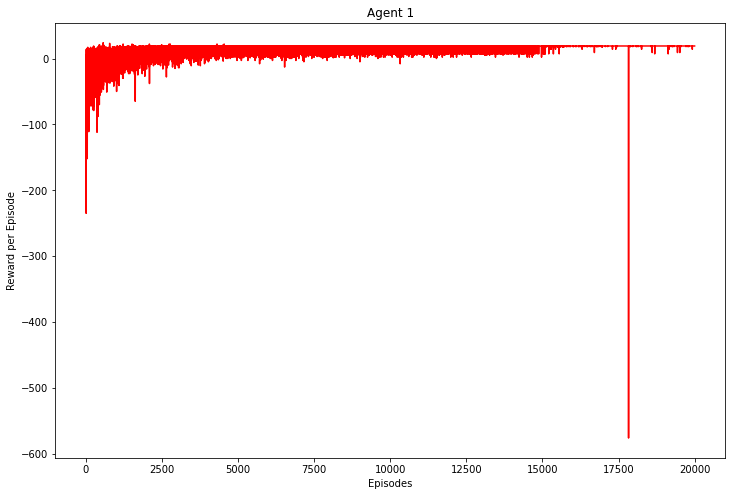

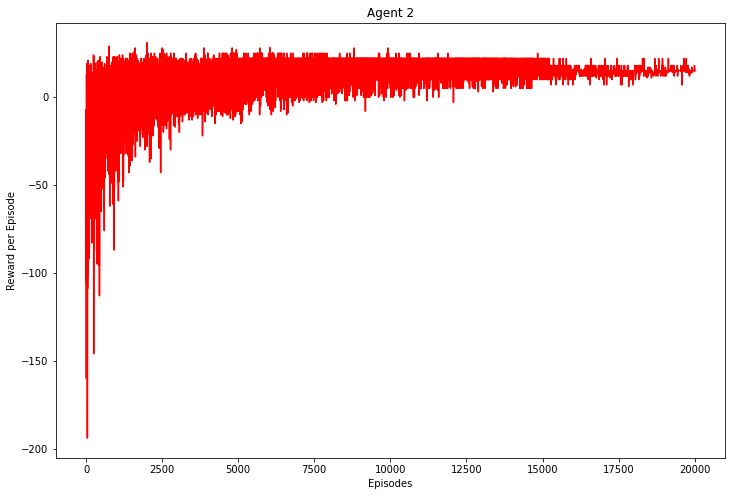

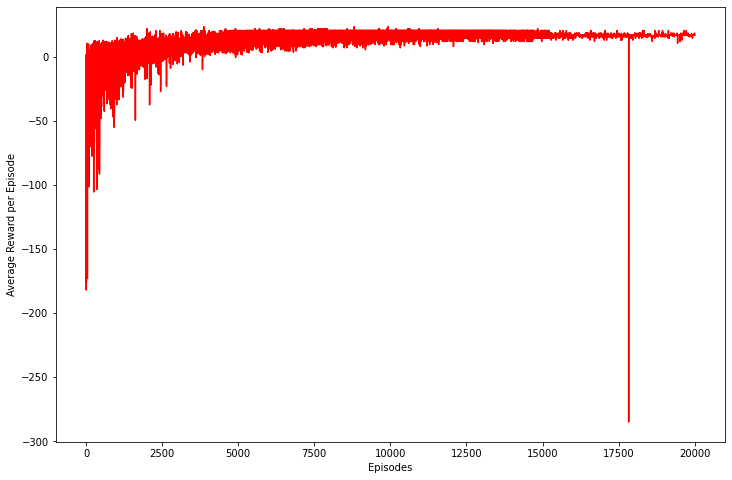

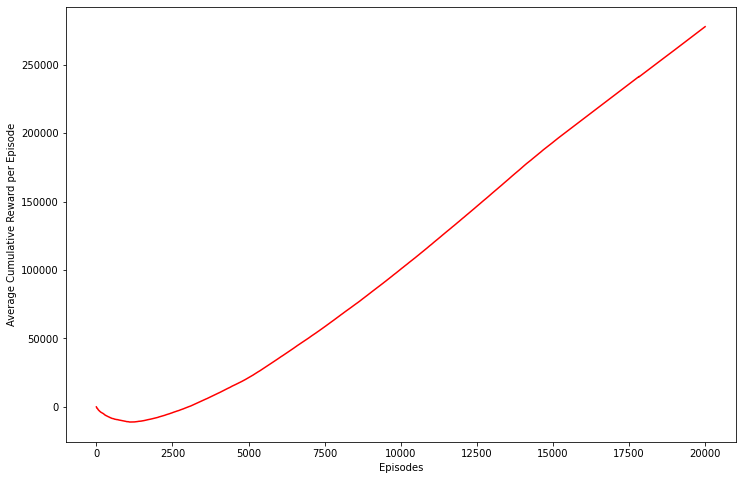

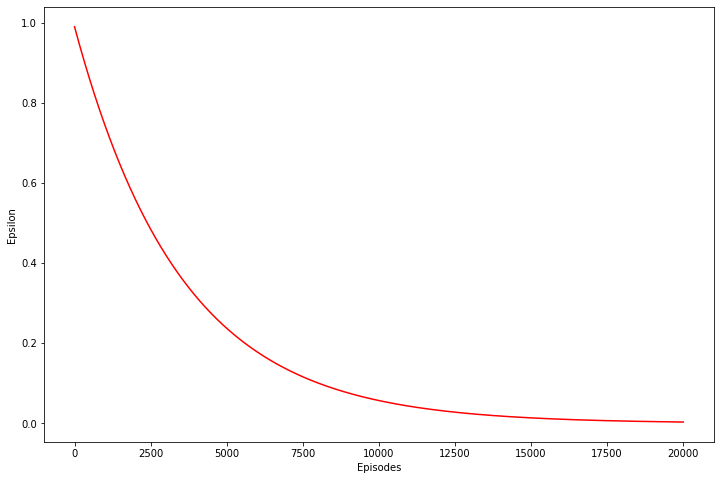

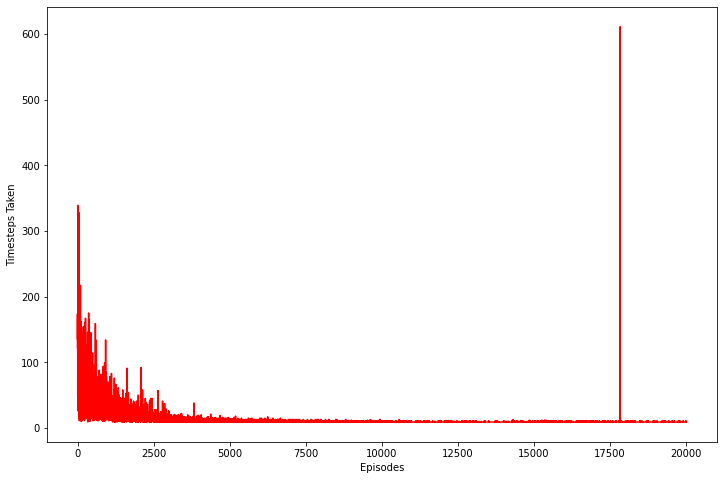

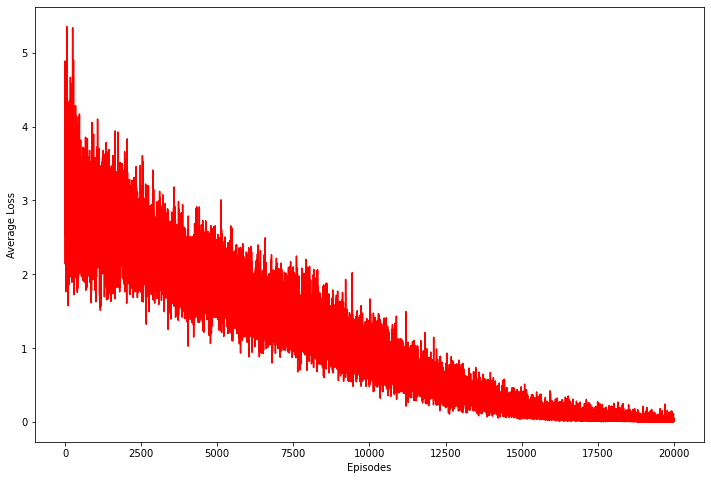

In [ ]:
dqn_model_ag1, dqn_model_ag2 = grid_world_main(num_episodes=20000, batch_size=128, gamma=0.90, learningrate=0.00005, epsilon_start=0.99, epsilon_final=0.0000001, epsilon_decay=3500)


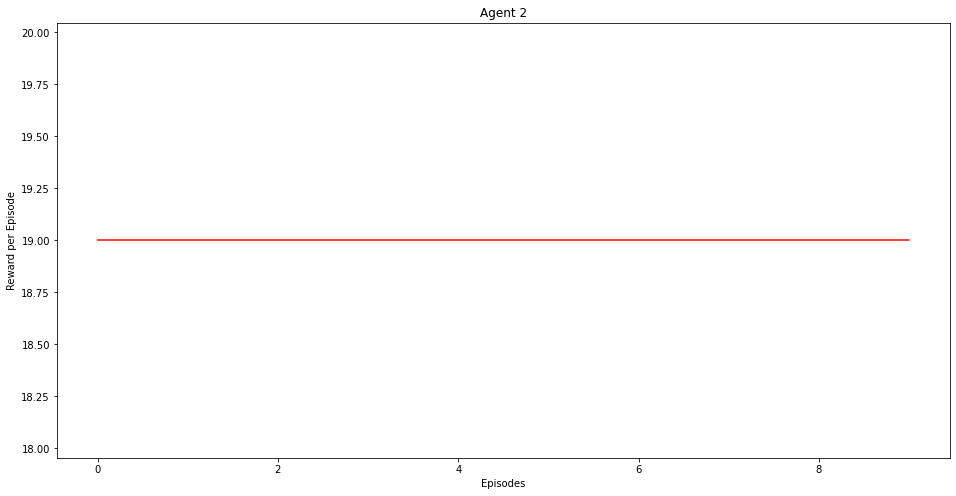

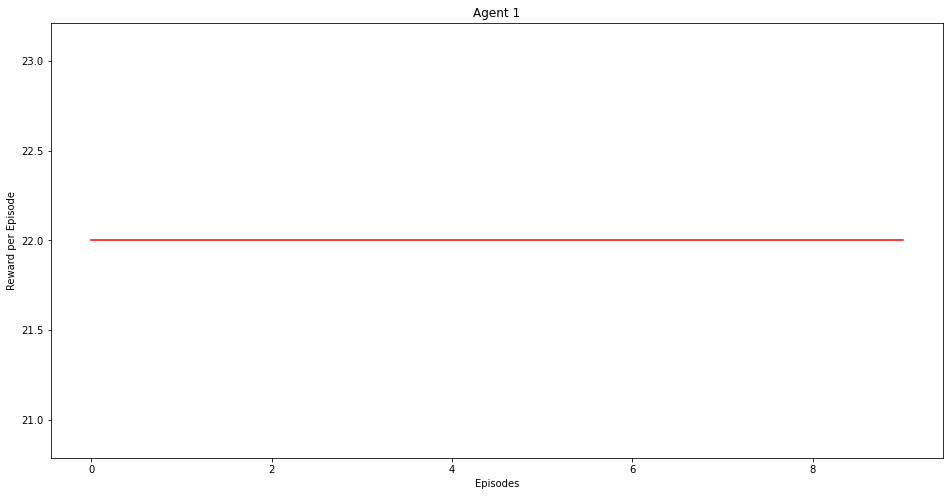

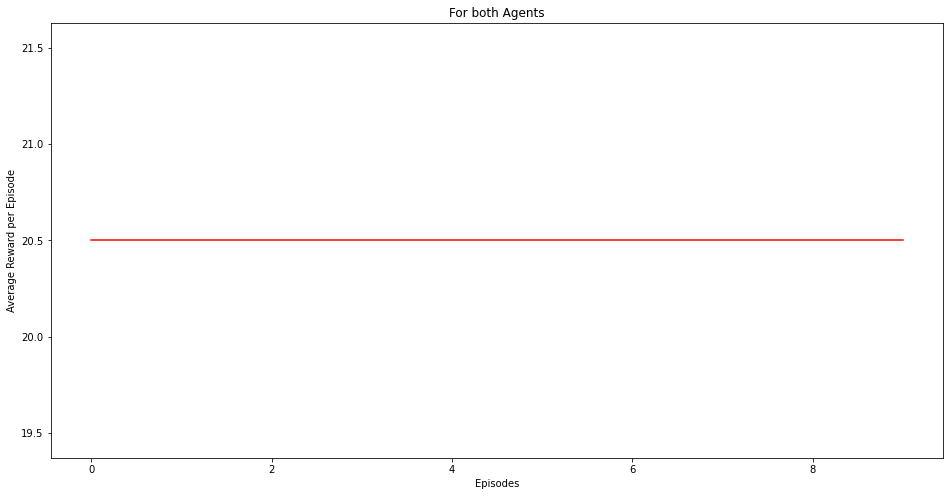

In [ ]:
evalTrainedModel(dqn_model_ag1, dqn_model_ag2)